In this project we will build a nice web app that allows you to swap out the background of a subject and substitute it with an image generated by Stable Diffusion through a text prompt:

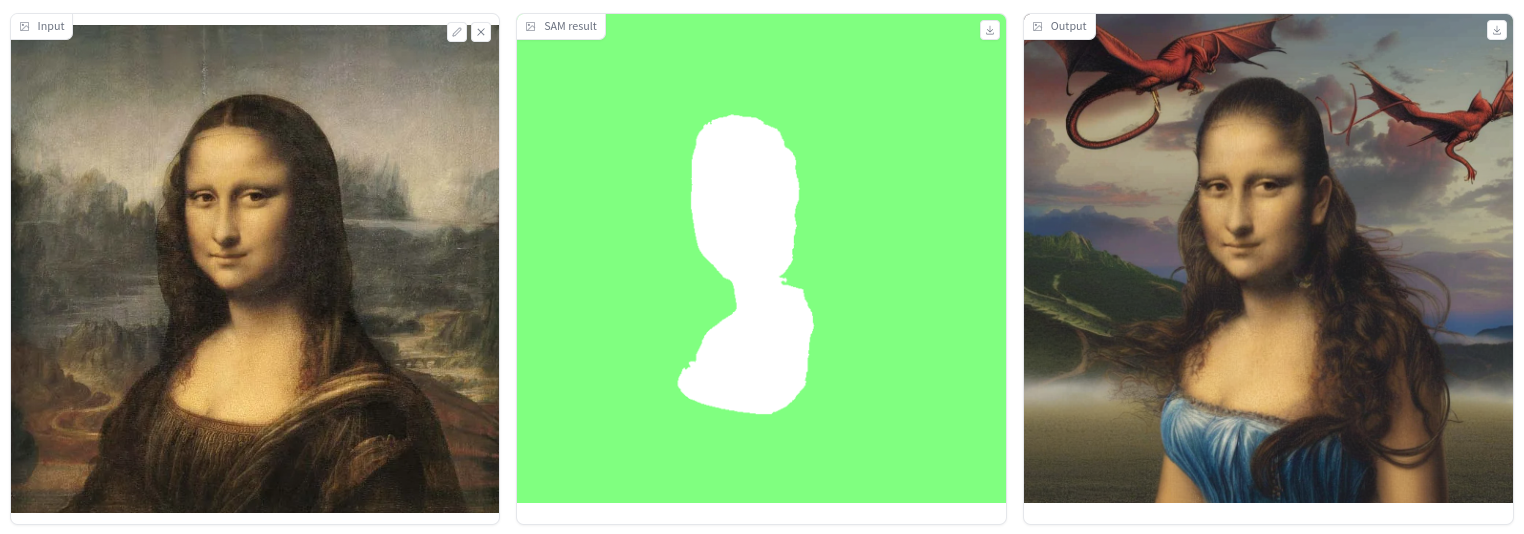

Let's start by importing what we need:

In [1]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from diffusers import DiffusionPipeline, AutoPipelineForText2Image, AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

import torch
import numpy as np

## SAM

Complete the following cell by loading the pretrained SAM from Facebook/Meta. Remember to:

1. Move the model to the GPU by adding `.to("cuda")`
2. Add the option `torch_dtype=torch.float16` to your call of AutoPipelineForInpainting.from_pretrained

This cell might take a couple of minutes to load.

In [2]:
# Load the SAM model and move it to GPU with float16 precision
model = SamModel.from_pretrained("facebook/sam-vit-base", torch_dtype=torch.float16).to("cuda")

# Load the SAM processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

### Get the mask

Now that you have loaded SAM, complete the following function that uses SAM to produce a segmentation mask:

In [3]:
def mask_to_rgb(mask):
    """
    Transforms a binary mask into an RGBA image for visualization
    """
    bg_transparent = np.zeros(mask.shape + (4, ), dtype=np.uint8)
    
    # Color the area we will replace in green
    # (this vector is [Red, Green, Blue, Alpha])
    bg_transparent[mask == 1] = [0, 255, 0, 127]
    
    return bg_transparent

def get_processed_inputs(image, input_points):
    # Convert image to numpy array
    image_np = np.array(image)

    # Use the processor to generate the right inputs for SAM
    inputs = processor(
        images=image_np, 
        input_points=input_points, 
        return_tensors='pt'
    ).to("cuda")

    # Load the SAM model (no need for AutoPipelineForInpainting)
    model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")

    # Ensure inputs stay in float32
    inputs['pixel_values'] = inputs['pixel_values'].to(torch.float32)

    # Call SAM model to get segmentation results
    outputs = model(**inputs)

    # Post-process the outputs of SAM to obtain the masks
    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(), 
        inputs["original_sizes"].cpu(), 
        inputs["reshaped_input_sizes"].cpu()
    )
    
    # Select the mask with the highest score
    best_mask = masks[0][0][outputs.iou_scores.argmax()]

    # Invert the mask so that the subject has value 0 and the background 1
    return ~best_mask.cpu().numpy()

Now let's test what we have done so far. By executing this cell you should get a visualization of the mask for the following car:

<img src='car.png' width="200px"></img>

Let's see what happens in this cell:
1. We open the image of the car and **we resize it to 512 by 512 pixels** (a square image). This makes things simpler for this project
2. We define a few points on the image that indicate where the car is
3. We use the function we have defined to generate a mask using SAM
4. We visualize the mask

The mask should look like this:

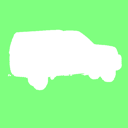

If it doesn't or you get errors, double check the code you have completed above and fix it before moving on.

Image type: <class 'PIL.Image.Image'>
Image size: (512, 512)


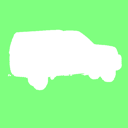

In [4]:
from PIL import Image
import os

# Specify the file path
image_path = "car.png"

# Check if the image file exists
if not os.path.exists(image_path):
    print(f"Error: {image_path} does not exist. Please check the file path.")
else:
    # Load the image and resize it to 512x512
    raw_image = Image.open(image_path).convert("RGB").resize((512, 512))

    # Check if the image is loaded correctly
    print(f"Image type: {type(raw_image)}")
    print(f"Image size: {raw_image.size}")

    # Now proceed if it's the correct type
    if isinstance(raw_image, Image.Image):
        # These are the coordinates of two points on the car
        input_points = [[[150, 170], [300, 250]]]

        try:
            # Get the segmentation mask using SAM
            mask = get_processed_inputs(raw_image, input_points)

            # Visualize the mask by transforming it into an RGB image
            mask_image = Image.fromarray(mask_to_rgb(mask)).resize((128, 128))

            # Display the mask image
            mask_image.show()

        except Exception as e:
            print(f"Error in processing: {e}")
    else:
        print("Error: Image not loaded properly.")

## Inpainting

Now that we have completed the SAM setup, let's move to the inpainting setup.

Let's start by loading our inpainting pipeline. We will use the `diffusers/stable-diffusion-xl-1.0-inpainting-0.1` pretrained model and the `AutoPipelineForInpainting` as we have seen in our `diffusers` demo in Lesson 5.

Complete the following code and run it (it might take a few minutes to run):

> **NOTE**: you will probably see a warning similar to ``The config attributes {'decay'...``. Please ignore it. It is a warning generated by the diffusers library that does not constitute a problem for our application

In [5]:
# Load the inpainting pipeline using DiffusionPipeline
pipeline = DiffusionPipeline.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16
).to("cuda")

# Enable model CPU offload for more efficient hardware usage
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Now complete the following function that gets in input:
1. The raw image
2. The mask generated by SAM (a numpy array)
3. The text prompt for the infill
4. An optional negative prompt
5. An optional seed for repeatibility
6. The Classifier-Free Guidance Scale (CFGS). If you don't remember what this is, refer to the Text Conditioning explanation in Lesson 5

In [6]:
def inpaint(raw_image, input_mask, prompt, negative_prompt=None, seed=74294536, cfgs=7):
    
    # Convert the input mask to a PIL image
    mask_image = Image.fromarray(input_mask)
    
    # Set the random generator seed for reproducibility
    rand_gen = torch.manual_seed(seed)
    
    # Use the inpainting pipeline with the provided parameters
    image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=raw_image,
        mask_image=mask_image,
        generator=rand_gen,
        guidance_scale=cfgs
    ).images[0]
    
    return image

Let's test our inpainting on the mask we have obtained earlier with SAM:

In [7]:
prompt = "a car driving on Mars. Studio lights, 1970s"
negative_prompt = "artifacts, low quality, distortion"

image = inpaint(raw_image, mask, prompt, negative_prompt)

  0%|          | 0/49 [00:00<?, ?it/s]

Let's have a look at what we have produced:

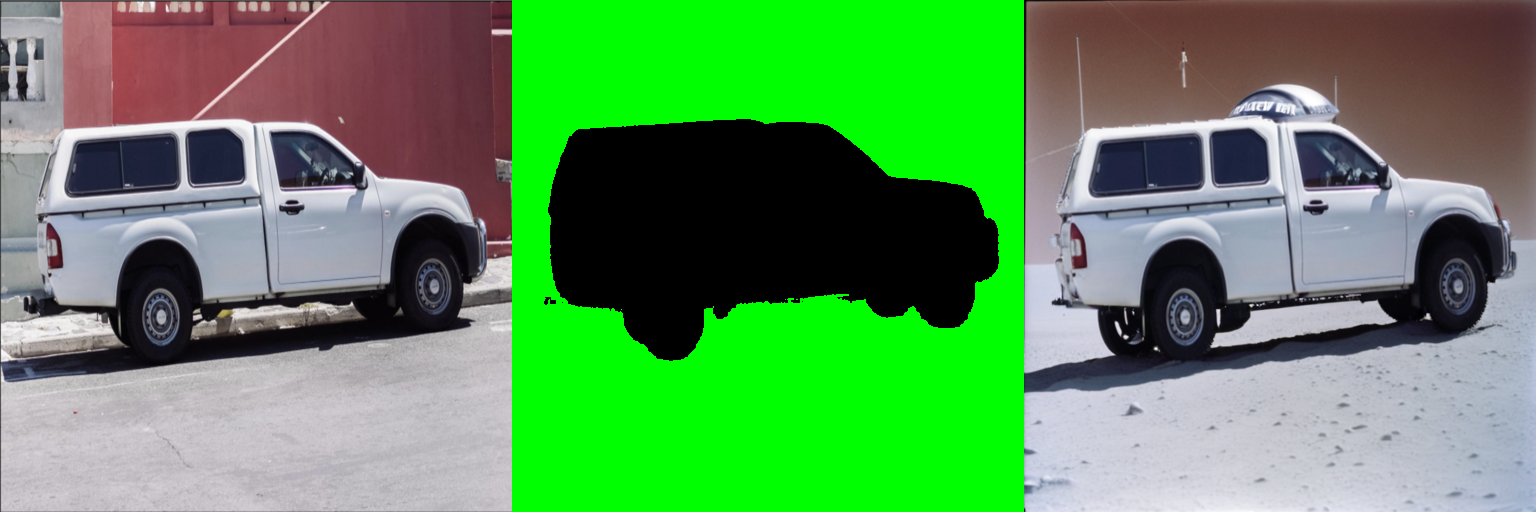

In [8]:
fig = make_image_grid([raw_image, Image.fromarray(mask_to_rgb(mask)), image.resize((512, 512))], rows=1, cols=3)
fig

## Interactive app

To make things a bit more fun, we have prepared an interactive app for you that uses the code you have completed and allow you to upload an image, run SAM, and generate the new background through a text prompt.

Simply execute the following cell. The output will contain a preview of the app: **DO NOT USE IT**. Instead, you will also see a link similar to this:

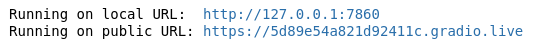

Click on the second link (the public URL), from there you will be able to use the app much more comfortably.

> NOTE: if for any reason you need to stop the app, click on the stop icon of the jupyter interface:   then **execute the next cell containing the code `my_app.close`**


In [9]:
import app

In [10]:
my_app = app.generate_app(get_processed_inputs, inpaint)

Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 3.50.2, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://89ef772d6516ad6d76.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


  0%|          | 0/49 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://89ef772d6516ad6d76.gradio.live


In [11]:
my_app.close()

Closing server running on port: 7860


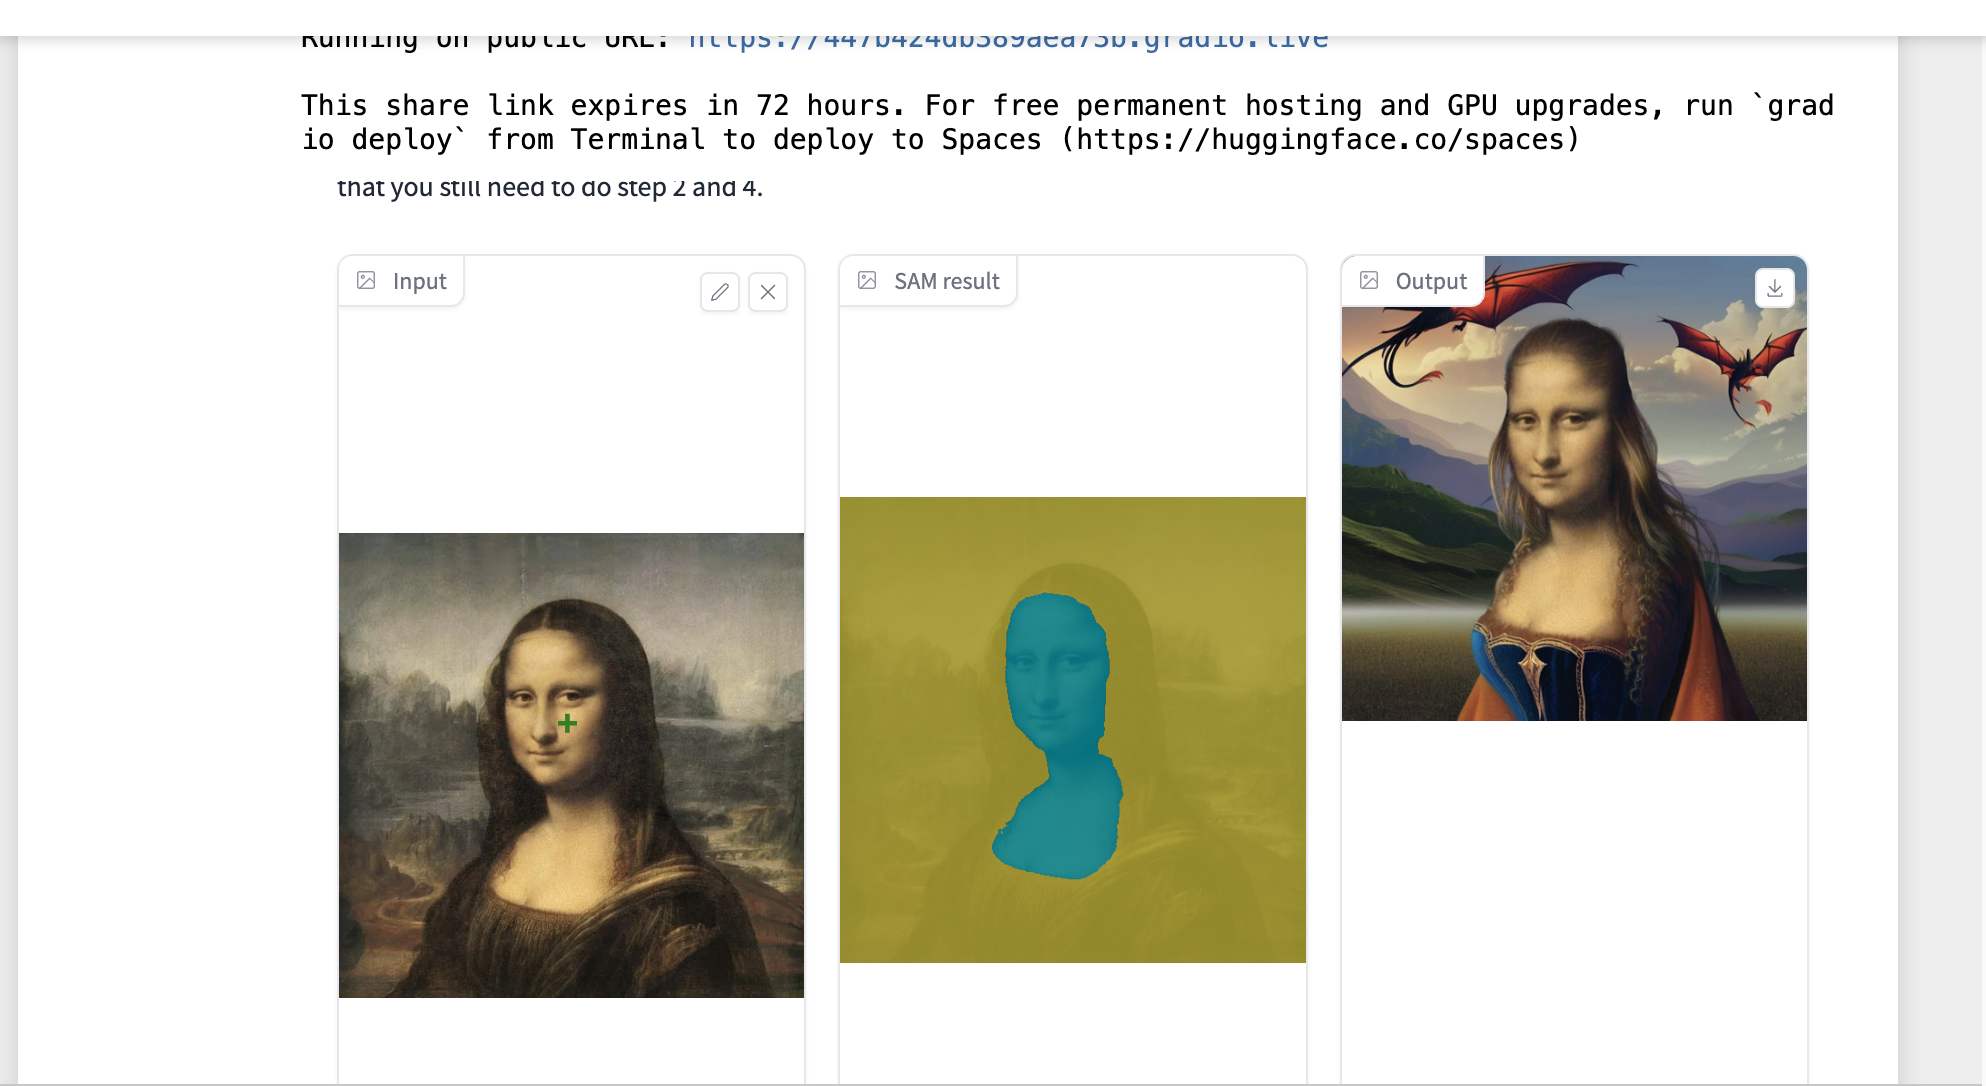

In [12]:
from IPython.display import Image
Image(filename='example.png')